<a href="https://colab.research.google.com/github/syphax/solar-data/blob/main/nb/Solar_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook analyses and visualizes output from my VT PV system.

To run with the provided data, you need Google Drive, and you need to copy the data from https://github.com/syphax/solar-data/tree/main/data to `/My Drive/Data/Solar`

_TODO: Load the data directly from the GitHub repo._

# Setup

In [53]:
import os

from datetime import datetime

import numpy as np
import pandas as pd

import altair as alt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

This loads data that was downloaded from [Green Mountain Power's website](https://greenmountainpower.com/account/usage/).

GMP has an excellent UI for reporting usage, and provides downloaded data in 15 minute increments (either CSV or Green Button XML). But unfortunately it only supports manual data downloads in 15 day (max) chunks. 

Fields in the CSV downloads are:
* `ServiceAgreement`: Account info
* `IntervalStart`: Timestamp; format is `yyyy-MM-dd-hh:mm:ss`
* `IntervalEnd`: Same, 15 minutes later. Redundant but explicit!
* `Quantity`: Amount of electricity generated
* `UnitOfMeasure` `kWh`. I love that they have an explicit UoM field!


## Prep

In [3]:
path = '/content/drive/MyDrive/Data/Solar/'

In [4]:
# This should list the data files that you copied from https://github.com/syphax/solar-data/tree/main/data
!ls $path 

full_dataset.csv		 UsageData_2021-11-07_12Days.csv
UsageData_2021-05-23_14Days.csv  UsageData_2021-11-18_15Days.csv
UsageData_2021-06-06_14Days.csv  UsageData_2021-12-02_15Days.csv
UsageData_2021-06-20_14Days.csv  UsageData_2021-12-17_15Days.csv
UsageData_2021-07-04_14Days.csv  UsageData_2022-01-01_15Days.csv
UsageData_2021-07-18_14Days.csv  UsageData_2022-01-16_15Days.csv
UsageData_2021-08-01_14Days.csv  UsageData_2022-01-31_1Days.csv
UsageData_2021-08-15_14Days.csv  UsageData_2022-02-01_15Days.csv
UsageData_2021-08-29_14Days.csv  UsageData_2022-02-15_14Days.csv
UsageData_2021-09-12_14Days.csv  UsageData_2022-03-01_15Days.csv
UsageData_2021-09-26_14Days.csv  UsageData_2022-03-13_7Days.csv
UsageData_2021-10-10_14Days.csv  UsageData_2022-03-20_2Days.csv
UsageData_2021-10-24_14Days.csv


In [5]:
raw_input_files = os.path.join(path, 'UsageData*.csv')
joined_input_file = os.path.join(path, 'full_dataset.csv')

# TODO: Add 

In [6]:
# This concatenates available data files. We will need to remove possible dupes, and check for completeness.

!cat $raw_input_files > $joined_input_file

## Load

In [7]:
df_energy_data_raw = pd.read_csv(joined_input_file)

In [8]:
# What are the unique values for ServiceAgreement?

df_energy_data_raw['ServiceAgreement'].unique()

array(['POOLER, MADELEINE / Residential Net Metering / NGEN / 06-04-2021 12:00:00AM / Active',
       'POOLER, MADELEINE / Residential Net Metering / N01 / 06-04-2021 12:00:00AM / Active',
       'POOLER, MADELEINE / Residential Water Heater / RE03 / 06-04-2021 12:00:00AM / Active',
       'POOLER, MADELEINE / Interconnected Generation Residential / INTC / 06-04-2021 12:00:00AM / Active',
       'ServiceAgreement'], dtype=object)

## Clean

In [20]:
sh0 = df_energy_data_raw.shape

df_solar_data = df_energy_data_raw[df_energy_data_raw['ServiceAgreement']=='POOLER, MADELEINE / Residential Net Metering / NGEN / 06-04-2021 12:00:00AM / Active']

# Remove any errant header rows (one may stick around in the data b/c it's not a dupe of the header row)
df_solar_data = df_solar_data[df_solar_data['ServiceAgreement'] != 'ServiceAgreement']

# Now we don't need that column anymore!
df_solar_data = df_solar_data.drop('ServiceAgreement', axis=1)

sh0 = df_solar_data.shape

df_solar_data = df_solar_data.drop_duplicates()

sh1 = df_solar_data.shape

cnt_dupes = sh0[0] - sh1[0]

print("Removed {:,} duplicate entries; {:,} left.".format(cnt_dupes, sh1[0]))

Removed 583 duplicate entries; 29,081 left.


In [23]:
# Set up data with the right types

df_solar_data['Quantity'] = df_solar_data['Quantity'].astype(np.float64)

fmt = '%Y-%m-%d-%H:%M:%S'

df_solar_data['dt_start'] = pd.to_datetime(df_solar_data['IntervalStart'], format=fmt)
df_solar_data['dt_end'] = pd.to_datetime(df_solar_data['IntervalEnd'], format=fmt)

In [26]:
for c in ['dt_start', 'dt_end']:  

  # Compute diffs vs prior record
  df_solar_data['diff_' + c] = df_solar_data[c].diff()

  # Add year, month, day, hour, minutes:

  df_solar_data[c + '_year'] = df_solar_data[c].dt.year
  df_solar_data[c + '_month'] = df_solar_data[c].dt.month
  df_solar_data[c + '_week'] = df_solar_data[c].dt.isocalendar().week
  df_solar_data[c + '_2weeks'] = np.ceil(df_solar_data[c].dt.isocalendar().week / 2.0) # Useful resolution
  df_solar_data[c + '_day'] = df_solar_data[c].dt.day
  
  # Altair doesn't like date types very much, so this is basically a rounded datetime
  df_solar_data[c + '_dt'] = pd.to_datetime(df_solar_data[c].dt.date)
  
  df_solar_data[c + '_hour'] = df_solar_data[c].dt.hour
  df_solar_data[c + '_minute'] = df_solar_data[c].dt.minute

  df_solar_data[c + '_hrmin'] = df_solar_data[c + '_hour'] + df_solar_data[c + '_minute'] / 60.0


In [27]:
# 15 minute increment:

d1 = datetime.strptime('2022-01-01-00:00:00', fmt)
d2 = datetime.strptime('2022-01-01-00:15:00', fmt)

diff_mins = (d2-d1)

In [28]:
# This should show the start of the series, plus some daylight savings impaired records!

df_solar_data[df_solar_data['diff_dt_start'] != diff_mins]

,IntervalStart,IntervalEnd,Quantity,UnitOfMeasure,dt_start,dt_end,diff_dt_start,dt_start_year,dt_start_month,dt_start_week,...,diff_dt_end,dt_end_year,dt_end_month,dt_end_week,dt_end_2weeks,dt_end_day,dt_end_dt,dt_end_hour,dt_end_minute,dt_end_hrmin
0,2021-05-23-00:00:00,2021-05-23-00:15:00,0.0,kWh,2021-05-23 00:00:00,2021-05-23 00:15:00,NaT,2021,5,20,...,NaT,2021,5,20,10.0,23,2021-05-23,0,15,0.25
59147,2021-10-24-01:00:00,2021-10-24-01:15:00,0.0,kWh,2021-10-24 01:00:00,2021-10-24 01:15:00,0 days 01:15:00,2021,10,42,...,0 days 01:15:00,2021,10,42,21.0,24,2021-10-24,1,15,1.25
64551,2021-11-07-01:45:00,2021-11-07-02:00:00,0.0,kWh,2021-11-07 01:45:00,2021-11-07 02:00:00,0 days 00:00:00,2021,11,44,...,0 days 01:00:00,2021,11,44,22.0,7,2021-11-07,2,0,2.00
110653,2022-03-13-03:00:00,2022-03-13-03:15:00,0.0,kWh,2022-03-13 03:00:00,2022-03-13 03:15:00,0 days 01:15:00,2022,3,10,...,0 days 00:15:00,2022,3,10,5.0,13,2022-03-13,3,15,3.25


# Review

# Summarize

In [29]:
df_solar_data_sums_by_day = df_solar_data.groupby(['dt_start_dt'], as_index=False).agg({'Quantity':'sum'})

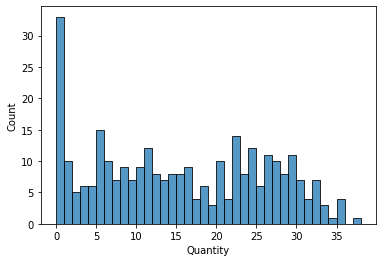

In [57]:
# Distribution of kWh by day, Narrow bins

sns.histplot(data=df_solar_data_sums_by_day, x="Quantity", binwidth = 1)

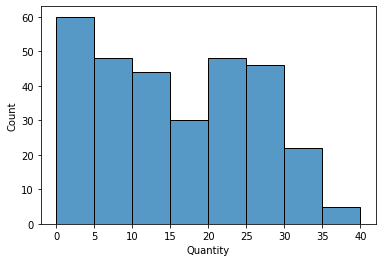

In [56]:
# Distribution of kWh by day, Wide bins

sns.histplot(data=df_solar_data_sums_by_day, x="Quantity", binwidth = 5)

In [18]:


alt.data_transformers.disable_max_rows()

ch = alt.Chart(df_solar_data_sums_by_day).mark_line().encode(
    x=alt.X('dt_start_dt:T'),
    y=alt.Y('Quantity:Q')
)

ch.display()

alt.Chart(...)

# Charts

In [52]:
df_ch = df_solar_data[['dt_start', 'dt_start_year', 'dt_start_month', 'dt_start_day', 
                       'dt_start_hour', 'dt_start_minute', 'dt_start_hrmin','Quantity']]

In [32]:
df_solar_data_sums_by_day.tail(7)

,dt_start_dt,Quantity
296,2022-03-15,1.96
297,2022-03-16,9.84
298,2022-03-17,22.15
299,2022-03-18,8.65
300,2022-03-19,3.02
301,2022-03-20,4.97
302,2022-03-21,27.46


# Extras

In [50]:
# Altair version (doesn't render in GitHub)

# Distribution of outputs by day (small bins)

ch_daily_hist = alt.Chart(df_solar_data_sums_by_day).mark_bar().encode(
    x = alt.X('Quantity', title='kWh', bin=alt.Bin(extent=[0, 40], step=1)), 
    y = alt.Y('count()', title='Days'))

ch_daily_hist.display()

alt.Chart(...)

In [51]:
# Distribution of outputs by day (larger bins)

ch_daily_hist = alt.Chart(df_solar_data_sums_by_day).mark_bar().encode(
    x = alt.X('Quantity', title='kWh', bin=alt.Bin(extent=[0, 40], step=4)), 
    y = alt.Y('count()', title='Days'))

ch_daily_hist.display()

alt.Chart(...)